In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import ast

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

from sklearn.model_selection import train_test_split

2025-07-27 23:28:09.951284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 23:28:09.953673: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 23:28:09.970233: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 23:28:10.019224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753639090.057224  104095 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753639090.06

cpu


In [2]:
df = pd.read_csv('audio_features.csv')
df_b = pd.read_csv('audio_balanced.csv')
df_77 = pd.read_csv('audio_balanced_77.csv')
train_df_balanced = pd.read_csv('train_balanced.csv')
test_df_balanced = pd.read_csv('test_balanced.csv')
df_bdown = pd.read_csv('audio_balanced_downsampled.csv')
train_df_bdown = pd.read_csv('train_balanced_downsampled.csv')
test_df_bdown = pd.read_csv('test_balanced_downsampled.csv')

# print table for sizes of df, df_balanced, df_balanced_downsampled, df_77, train_df_balanced, test_df_balanced, train_df_bdown, test_df_bdown
sizes_table = pd.DataFrame({
    'DataFrame': ['df', 'df_balanced', 'df_balanced_downsampled', 'df_77', 'train_df_balanced', 'test_df_balanced', 'train_df_bdown', 'test_df_bdown'],
    'No. of Samples': [len(df), len(df_b), len(df_bdown), len(df_77), len(train_df_balanced), len(test_df_balanced), len(train_df_bdown), len(test_df_bdown)]
})

sizes_table = sizes_table.set_index('DataFrame')
sizes_table = sizes_table.reset_index()
sizes_table = sizes_table.style.set_properties(**{'text-align': 'left'})
sizes_table = sizes_table.set_table_attributes('class="table table-striped"')
sizes_table = sizes_table.set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
sizes_table

,DataFrame,No. of Samples
0,df,196
1,df_balanced,306
2,df_balanced_downsampled,86
3,df_77,154
4,train_df_balanced,232
5,test_df_balanced,74
6,train_df_bdown,64
7,test_df_bdown,22


In [3]:
def get_train_test_split(df, val, reshape_val):
    ''' 
    df is a DataFrame with a 'Features' column containing string representations of numpy arrays.
    val is the test size for train_test_split.
    resshape val is like (-1, 1, 256) or (-1, 256) depending on the model input shape. thus it is a tuple.
    '''
    if type(df['Features'].iloc[0]) == str:
        df['Features'] = df['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
        
    X = np.stack(df['Features'].values)
    print("X shape before reshape:", X.shape)
    X = X.reshape(reshape_val)
    y = df['PHQ_Binary'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val, random_state=44)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    print("Train and Test Split:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")
    return X_train, X_test, y_train, y_test
    
    

In [4]:
if type(df_b['Features'].iloc[0]) == str:
    df_b['Features'] = df_b['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
X = np.stack(df_b['Features'].values)
print("X shape before reshape:", X.shape)
# X = X.reshape(-1, 1, 256)
X = X.reshape(-1, 16, 16)
y = df_b['PHQ_Binary'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=44)
print("Train and Test Split for Balanced:" f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

X shape before reshape: (306, 256)
Train and Test Split for Balanced:(244, 16, 16), (62, 16, 16), (244,), (62,)


In [5]:
X_train77, X_test77, y_train77, y_test77 = get_train_test_split(df_77, 0.2, (-1, 16, 16))
X_trainD, X_testD, y_trainD, y_testD = get_train_test_split(df_bdown, 0.2, (-1, 16, 16))

X shape before reshape: (154, 256)
Train and Test Split:(123, 16, 16), (31, 16, 16), (123,), (31,)
X shape before reshape: (86, 256)
Train and Test Split:(68, 16, 16), (18, 16, 16), (68,), (18,)


In [6]:
# evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")    
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

In [7]:
# plot graph of accuracy and loss over time in same figure
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epochs')

### GRU 32, 16, (1, 256), None

In [8]:
model = Sequential()
model.add(GRU(32, input_shape=(16, 16), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-27 23:28:14.994982: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,345 (20.88 KB)

 Trainable params: 5,345 (20.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = [10, 50, 100]

#### 1. Upsampled Balanced Dataset 

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5142 - loss: 0.6884 - val_accuracy: 0.6452 - val_loss: 0.6910
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5061 - loss: 0.6957 - val_accuracy: 0.6452 - val_loss: 0.6887
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5704 - loss: 0.6841 - val_accuracy: 0.6129 - val_loss: 0.6866
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5923 - loss: 0.6888 - val_accuracy: 0.5806 - val_loss: 0.6851
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5645 - loss: 0.6807 - val_accuracy: 0.5484 - val_loss: 0.6840
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5591 - loss: 0.6835 - val_accuracy: 0.5323 - val_loss: 0.6826
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5454 - loss: 0.6866 - val_accuracy: 0.5323 - val_loss: 0.6810
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5700 - loss: 0.6756 - val_accuracy: 0.5

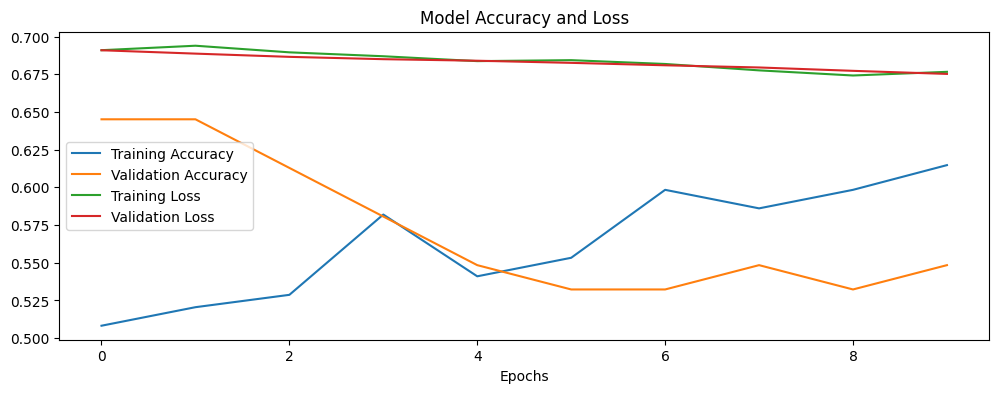

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5282 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6105 - loss: 0.6808 - val_accuracy: 0.5323 - val_loss: 0.6892
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5500 - loss: 0.6872 - val_accuracy: 0.5645 - val_loss: 0.6867
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5724 - loss: 0.6839 - val_accuracy: 0.5806 - val_loss: 0.6836
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5561 - loss: 0.6829 - val_accuracy: 0.5968 - val_loss: 0.6812
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5589 - loss: 0.6843 - val_accuracy: 0.5968 - val_loss: 0.6789
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6495 - loss: 0.6833 - val_accuracy: 0.6452 - val_loss: 0.6761
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6073 - loss: 0.6789 - val_accuracy: 0.6

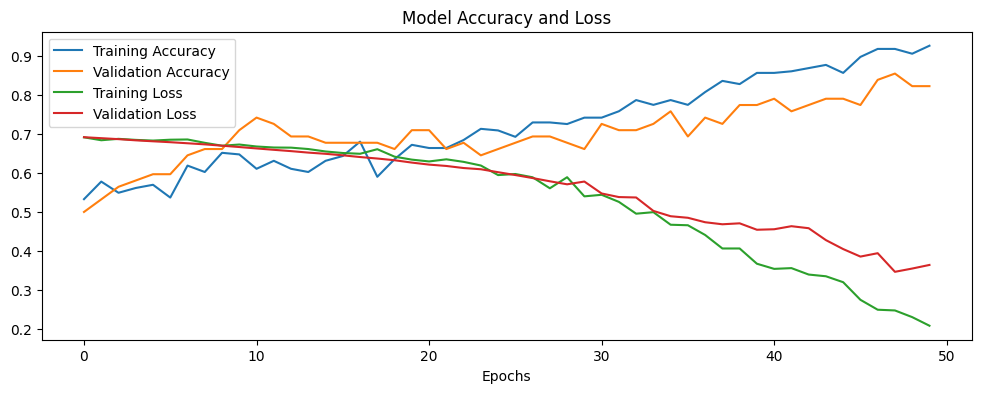

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.4646 - loss: 0.6985 - val_accuracy: 0.5968 - val_loss: 0.6931
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5369 - loss: 0.6930 - val_accuracy: 0.5645 - val_loss: 0.6918
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5312 - loss: 0.6914 - val_accuracy: 0.5484 - val_loss: 0.6902
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5293 - loss: 0.6873 - val_accuracy: 0.5806 - val_loss: 0.6885
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5876 - loss: 0.6885 - val_accuracy: 0.5968 - val_loss: 0.6872
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5670 - loss: 0.6864 - val_accuracy: 0.6290 - val_loss: 0.6859
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5310 - loss: 0.6890 - val_accuracy: 0.6774 - val_loss: 0.6845
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5829 - loss: 0.6838 - val_accu

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7ec5e813dc60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Accuracy: 0.8226
Precision: 0.7317
Recall: 1.0000
F1 Score: 0.8451


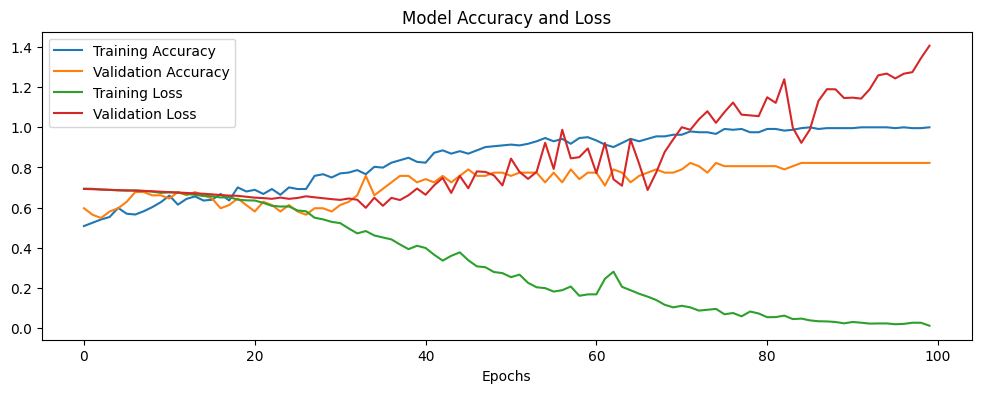

In [10]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(32, input_shape=(16, 16), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    model.save(f'saved_models/gru_model_{epoch}_32_16_1616.h5')

#### 2. 77 of each class

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5143 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5048 - loss: 0.6908 - val_accuracy: 0.4516 - val_loss: 0.6928
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4621 - loss: 0.6919 - val_accuracy: 0.4677 - val_loss: 0.6920
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6292 - loss: 0.6778 - val_accuracy: 0.4677 - val_loss: 0.6911
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5514 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5970 - loss: 0.6848 - val_accuracy: 0.5323 - val_loss: 0.6894
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5845 - loss: 0.6795 - val_accuracy: 0.5645 - val_loss: 0.6883
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6002 - loss: 0.6758 - val_accuracy: 0.5

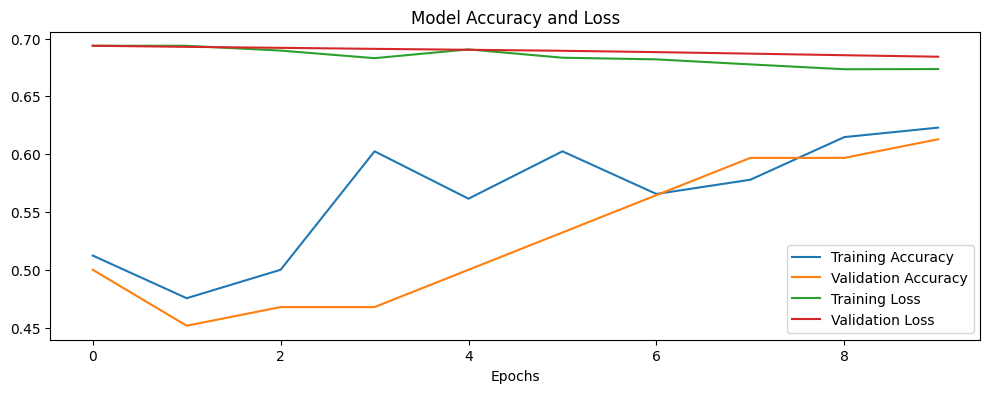

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5165 - loss: 0.6941 - val_accuracy: 0.4516 - val_loss: 0.6923
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5559 - loss: 0.6906 - val_accuracy: 0.4839 - val_loss: 0.6905
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5735 - loss: 0.6842 - val_accuracy: 0.5484 - val_loss: 0.6885
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5322 - loss: 0.6861 - val_accuracy: 0.5645 - val_loss: 0.6867
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6088 - loss: 0.6749 - val_accuracy: 0.6613 - val_loss: 0.6842
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6196 - loss: 0.6741 - val_accuracy: 0.6774 - val_loss: 0.6817
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5528 - loss: 0.6887 - val_accuracy: 0.6613 - val_loss: 0.6792
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5904 - loss: 0.6777 - val_accuracy: 0.6

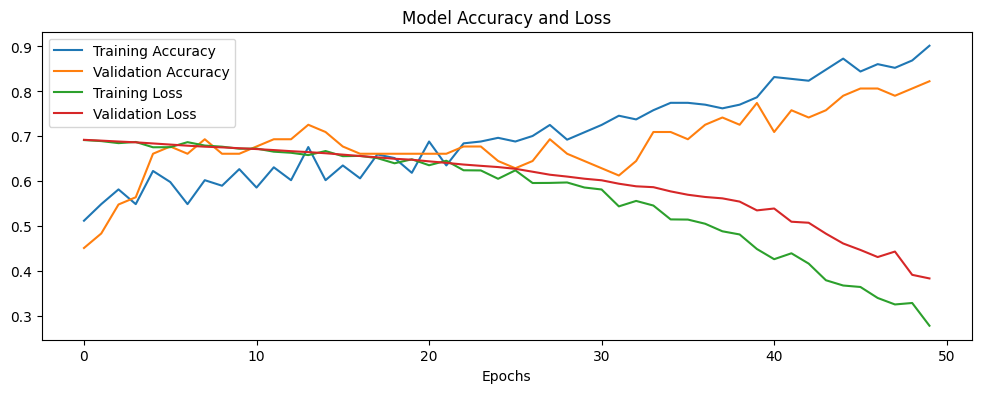

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.4951 - loss: 0.6914 - val_accuracy: 0.3548 - val_loss: 0.6979
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4960 - loss: 0.6904 - val_accuracy: 0.3871 - val_loss: 0.6960
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5270 - loss: 0.6841 - val_accuracy: 0.4516 - val_loss: 0.6939
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5693 - loss: 0.6905 - val_accuracy: 0.4677 - val_loss: 0.6918
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5558 - loss: 0.6856 - val_accuracy: 0.5161 - val_loss: 0.6901
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6140 - loss: 0.6761 - val_accuracy: 0.5161 - val_loss: 0.6887
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6249 - loss: 0.6764 - val_accuracy: 0.5323 - val_loss: 0.6872
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5758 - loss: 0.6848 - val_accu

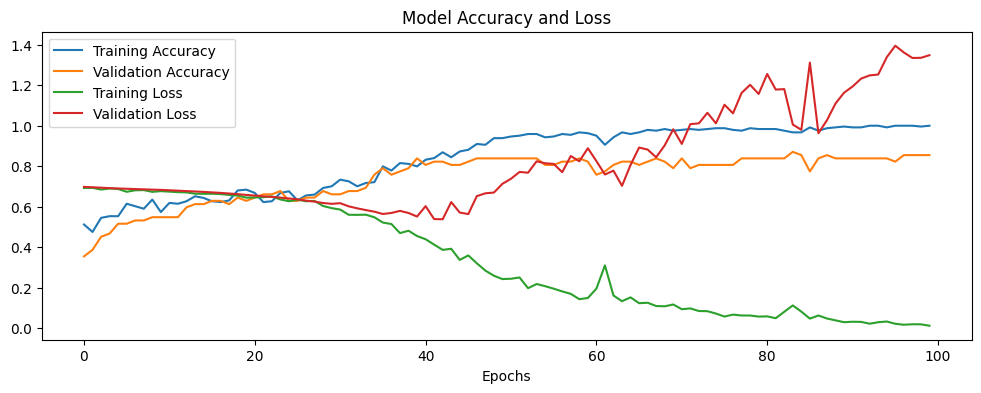

In [11]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(32, input_shape=(16, 16), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    # Save the model
    model.save(f'saved_models/gru_model_{epoch}_77_32_16_1616.h5')

#### 3. Downsampled Balanced Dataset

Training for 10 epochs
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.4751 - loss: 0.6957 - val_accuracy: 0.5323 - val_loss: 0.6934
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5321 - loss: 0.6894 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4316 - loss: 0.6943 - val_accuracy: 0.5645 - val_loss: 0.6903
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4885 - loss: 0.6905 - val_accuracy: 0.5968 - val_loss: 0.6886
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5378 - loss: 0.6848 - val_accuracy: 0.5968 - val_loss: 0.6869
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5733 - loss: 0.6841 - val_accuracy: 0.6129 - val_loss: 0.6849
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5749 - loss: 0.6832 - val_accuracy: 0.6129 - val_loss: 0.6832
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5851 - loss: 0.6798 - val_accuracy: 0.6

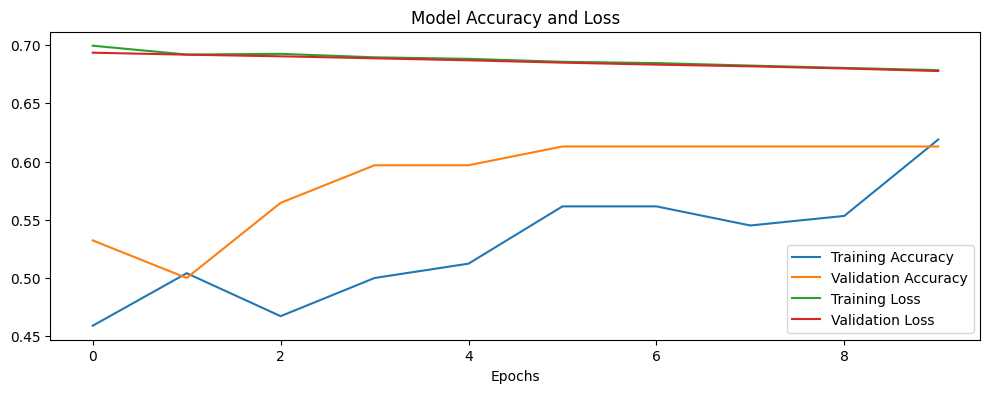

Training for 50 epochs
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5505 - loss: 0.6924 - val_accuracy: 0.4839 - val_loss: 0.7005
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5633 - loss: 0.6919 - val_accuracy: 0.4839 - val_loss: 0.6986
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6270 - loss: 0.6812 - val_accuracy: 0.5000 - val_loss: 0.6973
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5349 - loss: 0.6913 - val_accuracy: 0.5161 - val_loss: 0.6961
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5489 - loss: 0.6840 - val_accuracy: 0.5645 - val_loss: 0.6942
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5232 - loss: 0.6878 - val_accuracy: 0.5645 - val_loss: 0.6922
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6432 - loss: 0.6801 - val_accuracy: 0.5645 - val_loss: 0.6902
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4987 - loss: 0.6867 - val_accuracy: 0.5

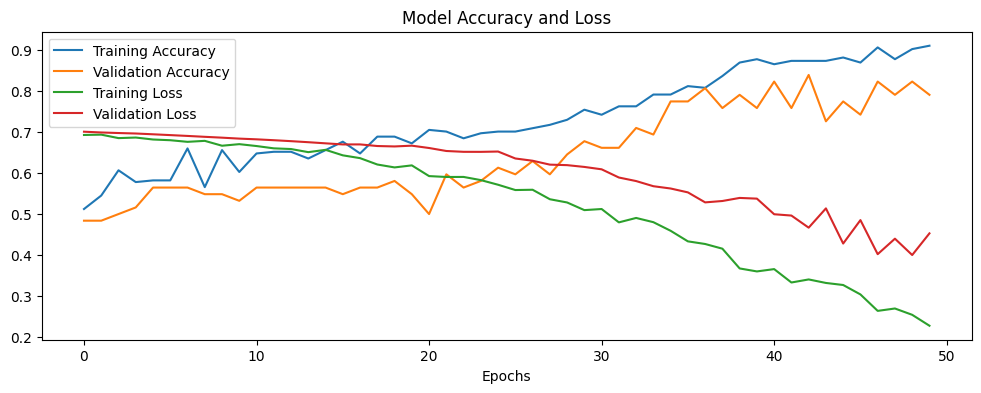

Training for 100 epochs
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4836 - loss: 0.6937 - val_accuracy: 0.5484 - val_loss: 0.6929
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4768 - loss: 0.6940 - val_accuracy: 0.5323 - val_loss: 0.6905
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5167 - loss: 0.6910 - val_accuracy: 0.5968 - val_loss: 0.6887
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5948 - loss: 0.6805 - val_accuracy: 0.5806 - val_loss: 0.6869
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5702 - loss: 0.6836 - val_accuracy: 0.5645 - val_loss: 0.6852
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5993 - loss: 0.6813 - val_accuracy: 0.5968 - val_loss: 0.6835
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5602 - loss: 0.6794 - val_accuracy: 0.5968 - val_loss: 0.6817
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6357 - loss: 0.6800 - val_accu

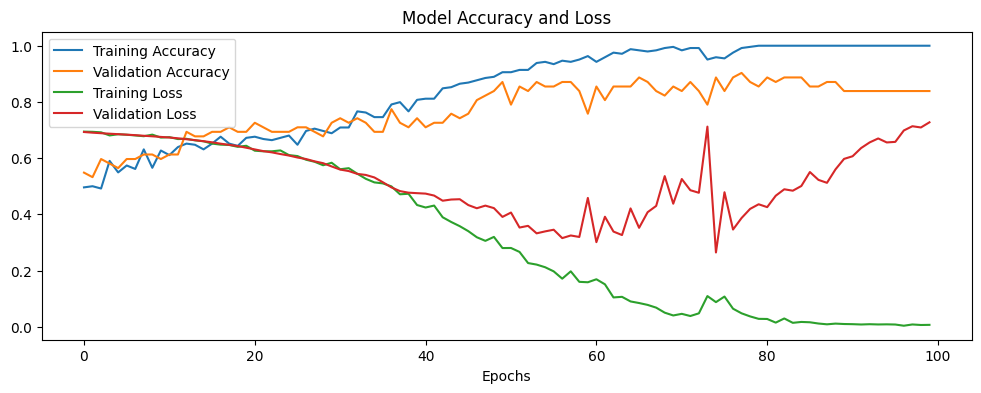

In [12]:
for epoch in epochs:
    print(f"Training for {epoch} epochs")
    model = Sequential()
    model.add(GRU(32, input_shape=(16, 16), return_sequences=False))  # single time step
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # binary classification
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
    evaluate_model(model, X_test, y_test)
    
    # Plot the training history
    plot_history(history)
    plt.show()
    
    # Save the model
    model.save(f'saved_models/gru_model_{epoch}_epochs.h5')  